Group:

ADONIS DARIO PIRES GOMES DE MORAIS: adpgm@cesar.school

MARLOS RIBEIRO: mgrb@cesar.school

LUIZ SIEBER: lssp@cesar.school

In [ ]:
# @title Library Imports
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import requests
import zipfile
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Data recovery and cleaning

In [ ]:
# Step 1: Download zip file from github
url = "https://raw.githubusercontent.com/adonisdario/cesar-school/main/Series-temporais/combustivel.zip"  # Substitua pela URL do arquivo zip no GitHub
response = requests.get(url)
zip_path = "combustivel.zip"

# Save zip file on Colab
with open(zip_path, "wb") as file:
    file.write(response.content)

print("Arquivo zip baixado com sucesso!")

# Step 2: Unpacking the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("conteudo_zip")
    print("Arquivo descompactado com sucesso!")

# Step 3: Load CSV in a Dataframe

# Listing the archives on a unpacked folder
for root, dirs, files in os.walk("conteudo_zip"):
    for file in files:
        if file.endswith(".csv"):
            csv_file_path = os.path.join(root, file)
            break

# Load CSV into the Dataframe
df = pd.read_csv(csv_file_path, sep=',')
print("DataFrame carregado com sucesso!")
df.head()

Arquivo zip baixado com sucesso!
Arquivo descompactado com sucesso!
DataFrame carregado com sucesso!


,Company Code,Order Number,Employee,Product,Product Category,Client,Client City,Sale Date Time,Product Cost,Discount Amount,Amount,Total,Form of payment
0,39000,164,Curtis Newman,Gasoline,Fuel,Customer not informed,No City,2017-03-31 07:17:00,3.043,0.0,25.991,92.24,Money
1,39000,219,Donna Bailey,Gasoline,Fuel,Rickey Castillo,Chiburgh,2017-03-31 07:59:00,3.043,0.0,15.002,53.24,Credit Card
2,39000,321,Terri Richards,Gasoline,Fuel,Customer not informed,No City,2017-03-31 09:02:00,3.043,0.0,8.454,30.00,Money
3,39000,1435,Devin Copeland,Gasoline,Fuel,Customer not informed,No City,2017-03-31 12:30:00,3.043,0.0,5.636,20.00,Money
4,39000,1435,Brandon Martin,Gasoline,Fuel,Customer not informed,No City,2017-03-31 12:30:00,3.043,0.0,36.631,130.00,Money


In [ ]:
# Total of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6612472 entries, 0 to 6612471
Data columns (total 13 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Company Code      int64  
 1   Order Number      int64  
 2   Employee          object 
 3   Product           object 
 4   Product Category  object 
 5   Client            object 
 6   Client City       object 
 7   Sale Date Time    object 
 8   Product Cost      float64
 9   Discount Amount   float64
 10  Amount            float64
 11  Total             float64
 12  Form of payment   object 
dtypes: float64(4), int64(2), object(7)
memory usage: 655.8+ MB


In [ ]:
# Total of Products
df['Product'].value_counts()

,count
Product,
Gasoline,6612472


In [ ]:
# Transform Sale Date Time column to datetime type
df['Sale Date Time'] = pd.to_datetime(df['Sale Date Time'])

In [ ]:
df.set_index('Sale Date Time', inplace=True)

In [ ]:
# Transform the records into daily records
serie_temporal = df['Product Cost'].resample('D').max()
serie_temporal = serie_temporal.dropna()

In [ ]:
# Day count
len(serie_temporal)

1099

In [ ]:
# @title Time series graph build
def periodo_serie(serie_temporal, tempo):
  if tempo == 'D':
    serie_temporal = df['Product Cost'].resample(tempo).max()
  else:
    serie_temporal = df['Product Cost'].resample(tempo).mean()
  serie_temporal = serie_temporal.dropna()
  return serie_temporal

def plot_serie_temporal(serie_temporal, title):
  plt.figure(figsize=(15, 5))
  plt.plot(serie_temporal)
  plt.title(f"Preço {title} da Gasolina") # Daily price of gasoline
  plt.xlabel("Ano-Mês") # Year-Month
  plt.ylabel("Preço Médio") # Avr Price
  plt.grid(True)
  plt.show()

# Daily price

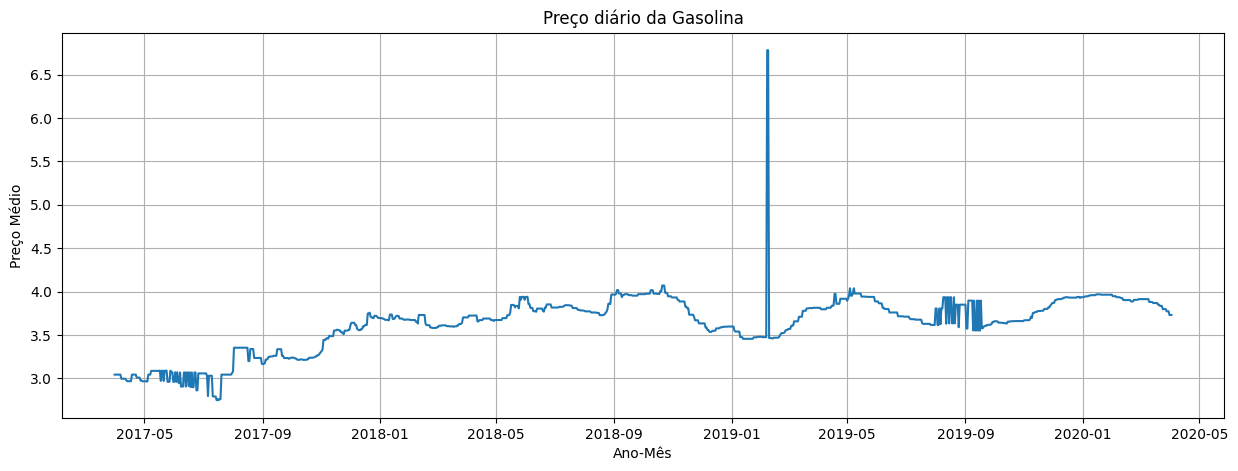

In [ ]:
plot_serie_temporal(periodo_serie(serie_temporal, 'D'), 'diário')

From the daily time series we observe:

* A price raise without many downs from month 07/2017 to month 11/2018
* High unstability between months 05 to 08 in 2017 and between months 08 to 10 in 2019, with fluctuation up to 💰 0.50
* Unpredictable peak at the start of 02/2019;
* Controlled fluctuation from 2018 to 2020.

# Monthly price

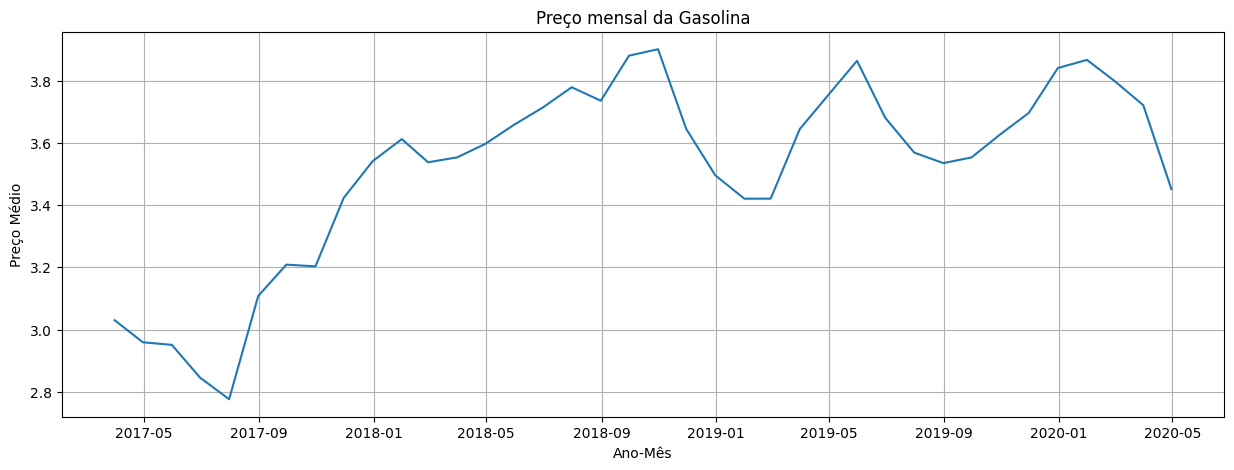

In [ ]:
plot_serie_temporal(periodo_serie(serie_temporal, 'M'), 'mensal')

From the monthly time series note that:

- Overall growth from 08/2017 to 11/2018;
- Price fluctuation between 💰4.00 e 💰3.40 from 11/2018 to 05/2020;
- Low period in months 08 and 09 of 2018 and 2019;
- High period in the 10th months across all years;

# Annually price

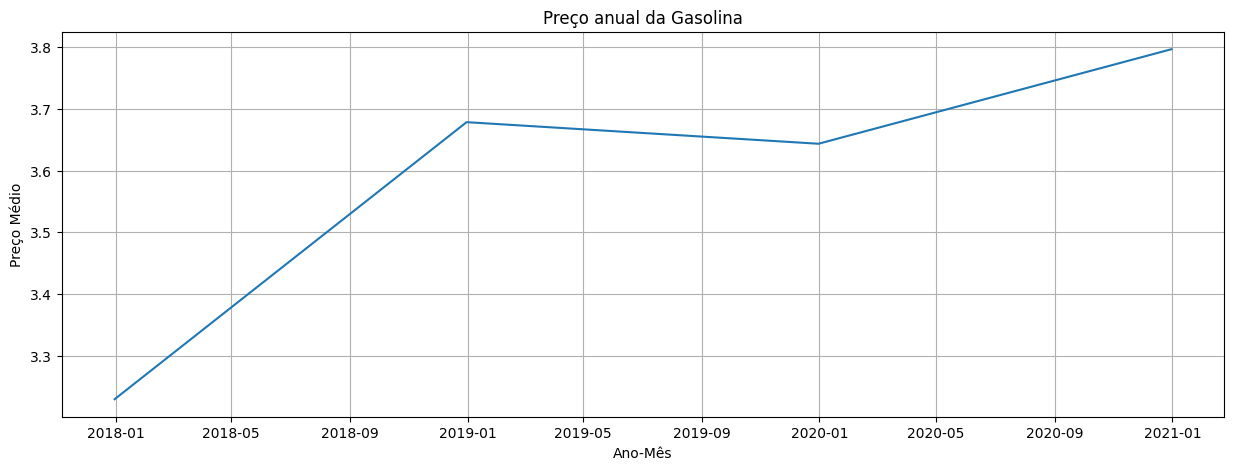

In [ ]:
plot_serie_temporal(periodo_serie(serie_temporal, 'Y'), 'anual')

In this annual time series:

- High from 2018 to 2019;
- Slight low from 2019 to 2020;
- Raise from 2020 to 2021;

Assuming that prices keep raising and lowering for brief periods, we can assume that the average price is not going to be lower that 💲 3.50 .

## Tendency, Seasoning and residual

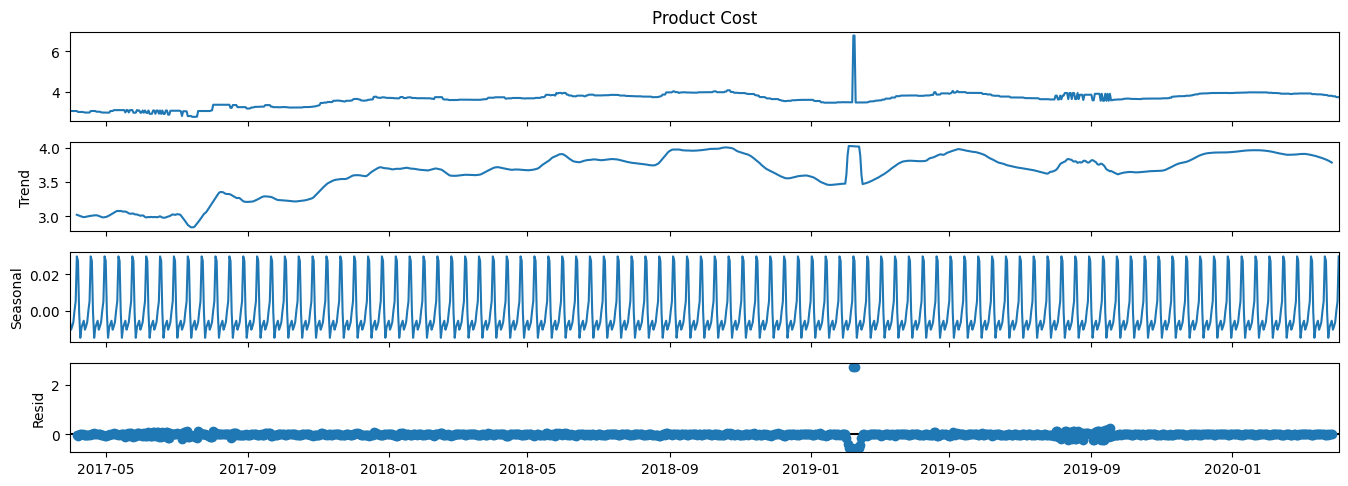

In [ ]:
# @title Daily time series with monthly analysis
season = seasonal_decompose(serie_temporal, period=12) # Period 1 = annual, 12 = monthly, 52 = weekly, 365 = daily
fig = season.plot();
fig.set_size_inches(15, 5)

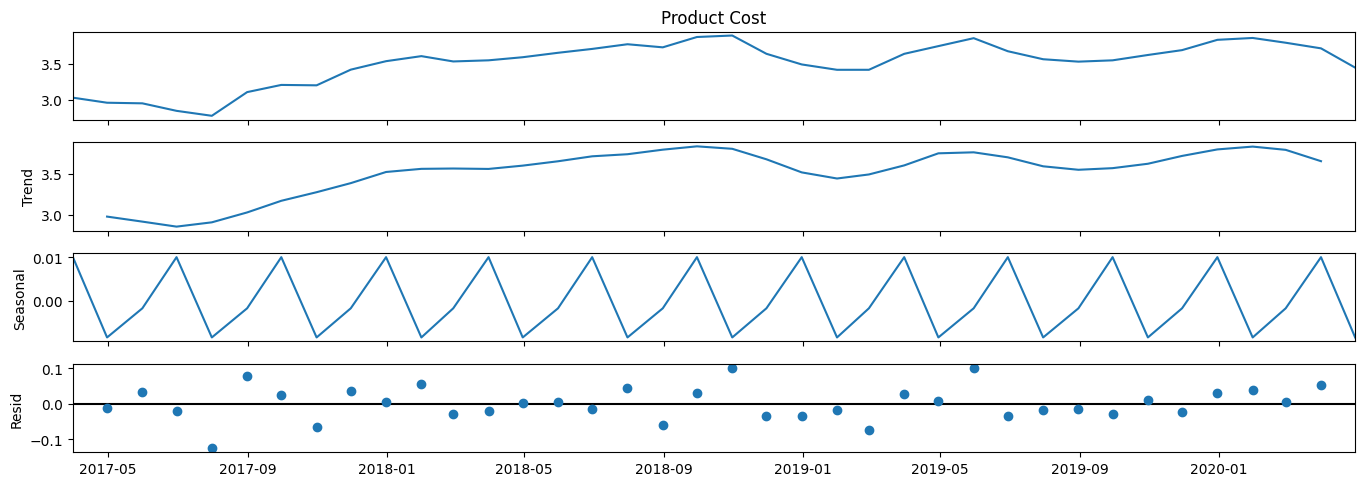

In [ ]:
# @title Monthly series with aurterly analysis
season = seasonal_decompose(periodo_serie(serie_temporal, 'M'), period=3) # Period 1 = annual, 12 = monthly, 52 = weekly, 365 = daily
fig = season.plot();
fig.set_size_inches(15, 5)

# Data Transformation

For the data to be stationary, Normalization and Differencing proccesses are needed.

In [ ]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

According to the Data Exploration, to eliminate the seasoning, it is necessary to differentiate by weekly prices.

In [ ]:
# Nomalizing and Differencing to make the series stationary
serie_temporal.index = pd.to_datetime(serie_temporal.index)  # Convert to datetime
df_N1, av_J1, std_J1 = Normalize(serie_temporal.to_frame(), "Product Cost")
Diff_1 = Difference(df_N1, col="Product Cost", interval=(24*7)) # taking a week's difference
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"] = Diff_1
df_N1 = df_N1.dropna()

In [ ]:
df_N1

,Norm,Diff
Sale Date Time,,
2017-09-15,-1.149745,0.666095
2017-09-16,-0.916459,0.899382
2017-09-17,-0.916459,0.899382
2017-09-18,-0.916459,0.899382
2017-09-19,-0.916459,0.899382
...,...,...
2020-03-29,0.424940,0.429739
2020-03-30,0.424940,0.429739
2020-03-31,0.292949,0.236356


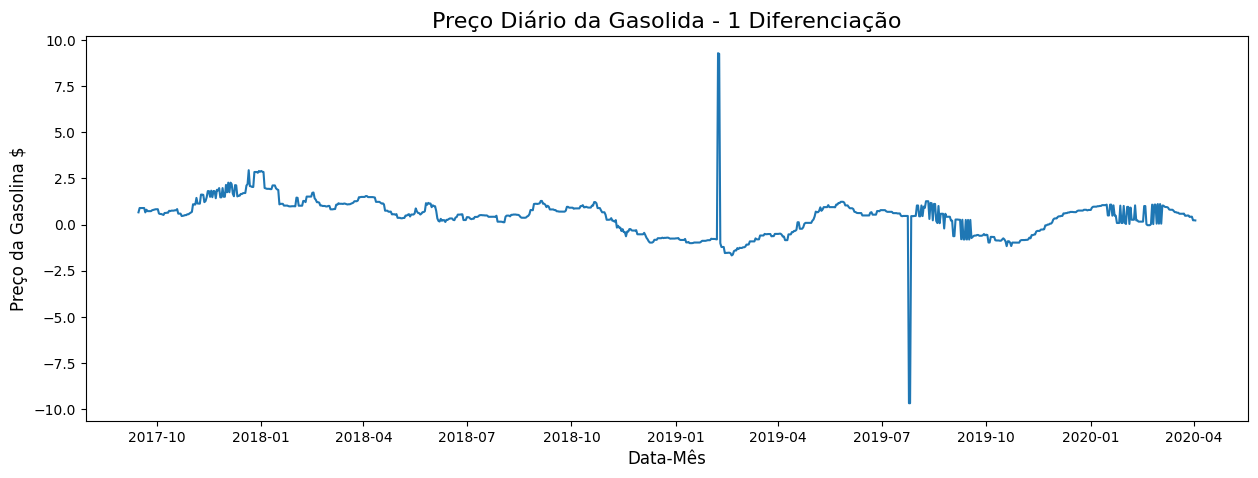

In [ ]:
import seaborn as sns

plt.figure(figsize=(15, 5))
sns.lineplot(data=df_N1, x=df_N1.index, y='Diff')

# Adicionar título e rótulos aos eixos
plt.title("Preço Diário da Gasolida - 1 Diferenciação", fontsize=16) # Gas daily price - 1 diff
plt.xlabel("Data-Mês", fontsize=12) # Year-Month
plt.ylabel("Preço da Gasolina $", fontsize=12) # Price
plt.show()

## Confirming the stationary status of the series

In [ ]:
# Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary")

print("Confirmando a estacionaridade da série")
Stationary_check(df_N1.Diff)

Confirmando a estacionaridade da série
ADF Statistic: -3.4512958602127846
p-value: 0.009329648331163438
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
Time Series is Stationary


# Train and Test Split

In [ ]:
# Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len]
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test


df_J1 = df_N1["Diff"]
df_J1 = df_J1.to_frame()
J1_train, J1_test = Split_data(df_J1)

# Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

# Shaping X_train and X_test
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

# Designating features e target
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

# Autocorrelation

To be predictable a unique variable series must be autocorrelated, meaning that the current period should have an explanation based on a previous period (lag).

In [ ]:
X_trainJ1.shape

(805, 32, 1)

In [ ]:
X_trainJ1.reshape(-1)

array([0.66609513, 0.8993819 , 0.8993819 , ..., 0.80422545, 0.80422545,
       0.77046026])

## Total and Partial Autocorrelation WITH Differentiation

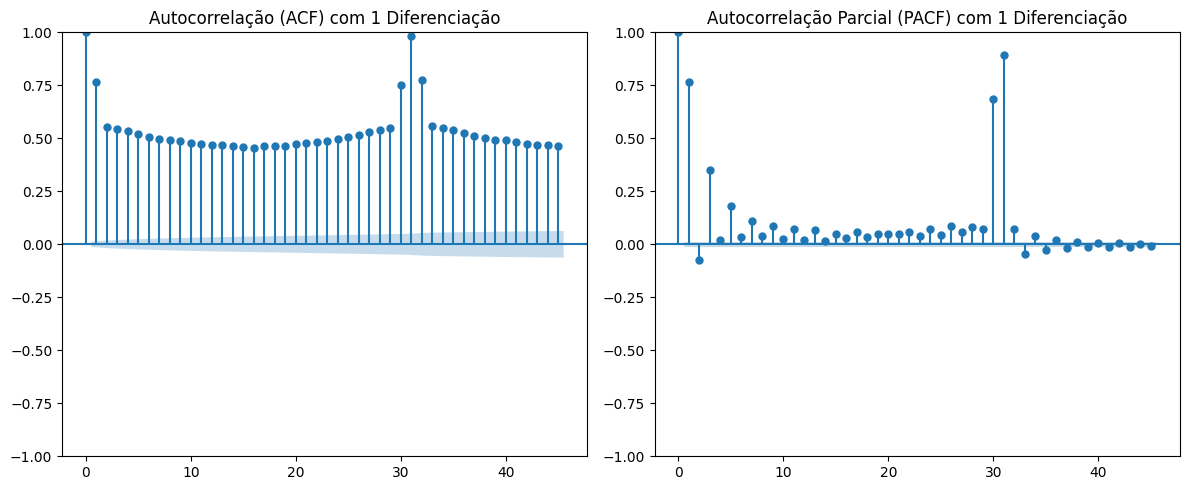

In [ ]:
# With differentiation
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 line, 2 cols

# Autocorrelation Graph (ACF)
plot_acf(X_trainJ1.reshape(-1), ax=axes[0])
axes[0].set_title("Autocorrelação (ACF) com 1 Diferenciação")

# Partial Autocorrelation graph (PACF)
plot_pacf(X_trainJ1.reshape(-1), ax=axes[1])
axes[1].set_title("Autocorrelação Parcial (PACF) com 1 Diferenciação")

# Ajustando layout
plt.tight_layout()
plt.show()

With 1 Diff on Autocorrelation, almost half the lags have a relation of 0.5 or higher.

# Creating the GRU model

In [ ]:
def GRU_model(X_Train, y_Train, X_Test, n_epochs=50):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)

    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    # model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    # model.add(Dropout(0.2))
    # model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    # model.add(Dropout(0.2))
    # model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    # model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    # Compiling the model
    model.compile(optimizer=SGD(decay=1e-7, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train, y_Train, epochs=n_epochs, batch_size=150,callbacks=[early_stopping])
    pred_GRU = model.predict(X_Test)
    return pred_GRU

# Calculating the root mean squared error of the predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

def get_metrics(ground_truth, pred):
  mse = mean_squared_error(ground_truth, pred)
  rmse = np.sqrt(mean_squared_error(ground_truth, pred))
  mae = mean_absolute_error(ground_truth, pred)

  return {"mse": mse,
          "rmse": rmse,
          "mae": mae}

# Comparative plot between real and predicted
def PredictionsPlot(test,predicted):
    plt.figure(figsize=(12,5))
    plt.plot(test, label="Valores reais",alpha=0.5)
    plt.plot(predicted, label="Valores preditos")
    plt.title("GRU Predição Vs Real")
    plt.xlabel("Data")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

## Validating the model

In [ ]:
PredJ1 = GRU_model(X_trainJ1, y_trainJ1, X_testJ1)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.1857
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7335
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5944
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7024
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6986
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5061
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6130
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7460
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3681
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4277
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7663
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6503
Epoch 13/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5828
Epoch 14/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4223
Epoch 15/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8374
Epoch 16/50
6/6 ━━━━━━━━━━━━━━━━━━

# Results

The root mean squared error is 0.4206298052502357.


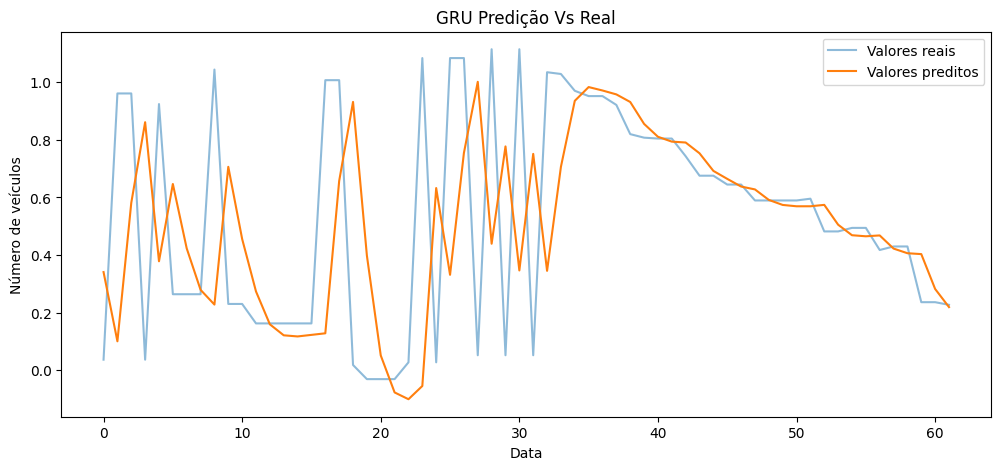

In [ ]:
RMSE_J1 = RMSE_Value(y_testJ1, PredJ1)
PredictionsPlot(y_testJ1, PredJ1)

In [ ]:
get_metrics(y_testJ1, PredJ1)

{'mse': 0.1769294330648512,
 'rmse': 0.4206298052502357,
 'mae': 0.2701041059800047}

The model was able to have a Mean Absolute Error of 0.27